In [5]:
import torch
from pathlib import Path

PHASE3_MODEL_DIR = "/home/lichengze/Research/CNN_pipeline/phase3_outputs/learning_rate/learning_rate_corrected/output/lr_7e-4"
fold = 0

# 这就是 exp1.py 中的那行代码
model_path = Path(PHASE3_MODEL_DIR) / f"fold_{fold}" / "best.pt"

# 注意：PyTorch 2.6+ 需要 weights_only=False 来加载包含 numpy 对象的文件
# 这是因为文件来自信任的来源（你自己的训练结果）
checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)

print("Keys in checkpoint:", list(checkpoint.keys()))
print("Done")

# 显示简单的值
for key in ['epoch', 'uno', 'uno_integral', 'clinical_dim', 'n_time_bins']:
    if key in checkpoint:
        print(f"{key}: {checkpoint[key]}")
        print("Finished")
# 显示 state_dict 信息
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
    print(f"\nState dict: {len(state_dict)} parameter tensors")
    print(f"Total parameters: {sum(p.numel() for p in state_dict.values()):,}")
    print("\nFirst 10 parameter names:")
    for name in list(state_dict.keys())[:10]:
        print(f"  {name}: {state_dict[name].shape}")

Keys in checkpoint: ['state_dict', 'cuts', 'epoch', 'uno_integral', 'uno_24m', 'harrell', 'lr', 'use_tta', 'clinical_features', 'clinical_dim', 'n_time_bins']
Done
epoch: 55
Finished
uno_integral: 0.5942091485661409
Finished
clinical_dim: 12
Finished
n_time_bins: 14
Finished

State dict: 59 parameter tensors
Total parameters: 14,826,926

First 10 parameter names:
  backbone.conv1.weight: torch.Size([64, 2, 7, 7, 7])
  backbone.bn1.weight: torch.Size([64])
  backbone.bn1.bias: torch.Size([64])
  backbone.layer1.0.conv1.weight: torch.Size([64, 64, 3, 3, 3])
  backbone.layer1.0.bn1.weight: torch.Size([64])
  backbone.layer1.0.bn1.bias: torch.Size([64])
  backbone.layer1.0.conv2.weight: torch.Size([64, 64, 3, 3, 3])
  backbone.layer1.0.bn2.weight: torch.Size([64])
  backbone.layer1.0.bn2.bias: torch.Size([64])
  backbone.layer2.0.conv1.weight: torch.Size([128, 64, 3, 3, 3])


In [9]:
#!/usr/bin/env python
"""
快速Baseline测试：用简单的CoxPH验证特征质量
目的：排除DeepSurv训练问题
"""
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv
import joblib

from pathlib import Path

# 路径配置（与 exp1.py 保持一致）
FEATURES_DIR = Path("/home/lichengze/Research/DeepFeature/myresearch/Exp1/features")
PHASE3_MODEL_DIR = Path("/home/lichengze/Research/CNN_pipeline/phase3_outputs/learning_rate/learning_rate_corrected/output/lr_7e-4")
CROP_LOG_CSV = "/home/lichengze/Research/CNN_pipeline/phase2_outputs/crop_log.csv"
CLINICAL_CSV = "/home/lichengze/Research/CNN_pipeline/NSCLC-Radiomics-Lung1.clinical.csv"

print("="*70)
print("Quick Baseline Test: CoxPH on extracted features")
print("="*70)

# 加载manifest
crop = pd.read_csv(CROP_LOG_CSV)
clinical = pd.read_csv(CLINICAL_CSV)

# 列映射（与 exp1.py 保持一致，确保所有12个临床特征都能正确映射）
col_map = {}
for col in clinical.columns:
    col_clean = col.lower().strip()
    if 'patient' in col_clean or 'case' in col_clean:
        col_map[col] = 'patient_id'
    elif 'survival' in col_clean and 'time' in col_clean:
        col_map[col] = 'time'
    elif 'dead' in col_clean or 'event' in col_clean:
        col_map[col] = 'event'
    elif 'overall' in col_clean and 'stage' in col_clean:
        col_map[col] = 'overall_stage'
    elif ('.t.' in col_clean or col_clean.startswith('t.') or '.t' in col_clean) and 'stage' in col_clean:
        col_map[col] = 'T'
    elif ('.n.' in col_clean or col_clean.startswith('n.') or '.n' in col_clean) and 'stage' in col_clean:
        col_map[col] = 'N'
    elif ('.m.' in col_clean or col_clean.startswith('m.') or '.m' in col_clean) and 'stage' in col_clean:
        col_map[col] = 'M'
    elif 'age' in col_clean and 'stage' not in col_clean:
        col_map[col] = 'age'
    elif 'gender' in col_clean or 'sex' in col_clean:
        col_map[col] = 'gender'

clinical = clinical.rename(columns=col_map)
manifest = crop[["patient_id", "out_ct", "out_edt"]].merge(
    clinical, on="patient_id", how="inner"
)
manifest = manifest.dropna(subset=["time", "event"])
manifest["time"] = manifest["time"].astype(int)
manifest["event"] = manifest["event"].astype(int)

print(f"Dataset: {len(manifest)} patients\n")

# 导入 exp1 模块中的函数（确保路径正确）
import sys
sys.path.insert(0, str(Path("/home/lichengze/Research/DeepFeature/myresearch/Exp1")))
from exp1 import prepare_clinical_no_scale

results = []

for fold in range(5):
    print(f"Fold {fold}:")
    
    # 加载特征（从 FEATURES_DIR）
    train_deep = np.load(str(FEATURES_DIR / f"fold{fold}_train_features.npy"))
    val_deep = np.load(str(FEATURES_DIR / f"fold{fold}_val_features.npy"))
    
    # 加载索引文件（优先从 FEATURES_DIR，如果不存在则从 Phase3 模型目录）
    idx_train_path_feat = FEATURES_DIR / f"fold{fold}_train_idx.npy"
    idx_val_path_feat = FEATURES_DIR / f"fold{fold}_val_idx.npy"
    idx_train_path_phase3 = PHASE3_MODEL_DIR / f"fold_{fold}" / "train_idx.npy"
    idx_val_path_phase3 = PHASE3_MODEL_DIR / f"fold_{fold}" / "val_idx.npy"
    
    if idx_train_path_feat.exists() and idx_val_path_feat.exists():
        # 优先使用 FEATURES_DIR 中的索引文件（如果特征提取后保存了）
        idx_train = np.load(str(idx_train_path_feat))
        idx_val = np.load(str(idx_val_path_feat))
        print(f"  Loaded indices from FEATURES_DIR")
    elif idx_train_path_phase3.exists() and idx_val_path_phase3.exists():
        # 如果不存在，从 Phase3 模型目录加载
        idx_train = np.load(str(idx_train_path_phase3))
        idx_val = np.load(str(idx_val_path_phase3))
        print(f"  Loaded indices from Phase3 model directory")
    else:
        raise FileNotFoundError(
            f"Fold {fold}: Cannot find index files. Checked:\n"
            f"  - {idx_train_path_feat}\n"
            f"  - {idx_val_path_phase3}"
        )
    
    # 临床特征（使用与 exp1.py 相同的函数，会提取12个特征）
    clinical_train, clinical_val = prepare_clinical_no_scale(
        manifest, idx_train, idx_val
    )
    
    # 验证临床特征数量（应该是12个：age, age_missing, gender_male, T, T_missing, N, N_missing, M01, M_missing, M_misc, overall_stage_ord, overall_missing）
    expected_clinical_features = 12
    actual_clinical_features = clinical_train.shape[1]
    if actual_clinical_features != expected_clinical_features:
        print(f"  ⚠️  Warning: Expected {expected_clinical_features} clinical features, but got {actual_clinical_features}")
        print(f"     This may happen if some clinical columns (T, N, M, overall_stage) are missing from the dataset.")
        print(f"     Please check if all required columns are properly mapped in the col_map above.")
    else:
        print(f"  ✓ Extracted {actual_clinical_features} clinical features (as expected)")
    
    # 组合
    X_train = np.hstack([train_deep, clinical_train])
    X_val = np.hstack([val_deep, clinical_val])
    
    print(f"  Combined features: Train {X_train.shape}, Val {X_val.shape}")
    print(f"    Deep features: {train_deep.shape[1]}-d, Clinical features: {clinical_train.shape[1]}-d")
    
    # 标准化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # 标签
    y_train = manifest.iloc[idx_train][['event', 'time']].values
    y_val = manifest.iloc[idx_val][['event', 'time']].values
    
    y_train_surv = Surv.from_arrays(
        event=y_train[:, 0].astype(bool),
        time=y_train[:, 1]
    )
    y_val_surv = Surv.from_arrays(
        event=y_val[:, 0].astype(bool),
        time=y_val[:, 1]
    )
    
    # ============================================================
    # 测试1: PCA降维 + CoxPH
    # ============================================================
    pca = PCA(n_components=50)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    
    cox_pca = CoxPHSurvivalAnalysis()
    cox_pca.fit(X_train_pca, y_train_surv)
    
    # 预测
    risks_pca = cox_pca.predict(X_val_pca)
    
    # 评估@24m
    try:
        uno_pca = concordance_index_ipcw(
            y_train_surv, y_val_surv, risks_pca, tau=730
        )[0]
    except:
        uno_pca = np.nan
    
    # ============================================================
    # 测试2: 全特征 + CoxPH (会很慢，但能看极限)
    # ============================================================
    try:
        cox_full = CoxPHSurvivalAnalysis(alpha=0.1)  # 加点正则避免奇异
        cox_full.fit(X_train, y_train_surv)
        
        risks_full = cox_full.predict(X_val)
        
        uno_full = concordance_index_ipcw(
            y_train_surv, y_val_surv, risks_full, tau=730
        )[0]
    except Exception as e:
        print(f"  Full CoxPH failed: {e}")
        uno_full = np.nan
    
    print(f"  CoxPH + PCA(50):   Uno@24m = {uno_pca:.4f}")
    print(f"  CoxPH + Full({X_train.shape[1]}): Uno@24m = {uno_full:.4f}")
    print()
    
    results.append({
        'fold': fold,
        'cox_pca': uno_pca,
        'cox_full': uno_full
    })

# 汇总
results_df = pd.DataFrame(results)

print("="*70)
print("BASELINE TEST SUMMARY")
print("="*70)
print(f"CoxPH + PCA(50):   {results_df['cox_pca'].mean():.4f} ± {results_df['cox_pca'].std():.4f}")
total_features = 512 + 12  # Deep features (512) + Clinical features (12)
print(f"CoxPH + Full({total_features}): {results_df['cox_full'].mean():.4f} ± {results_df['cox_full'].std():.4f}")
print()
print("解读:")
print("  如果CoxPH > 0.60 → 特征质量OK，DeepSurv训练需要优化")
print("  如果CoxPH < 0.58 → 特征质量不够，需要特征工程")
print("="*70)

Quick Baseline Test: CoxPH on extracted features
Dataset: 422 patients

Fold 0:
  Loaded indices from FEATURES_DIR
  Extracted 12 clinical features:
    age, age_missing, gender_male, T, T_missing, N, N_missing, M01, M_missing, M_misc, overall_stage_ord, overall_missing
  ✓ Extracted 12 clinical features (as expected)
  Combined features: Train (337, 524), Val (85, 524)
    Deep features: 512-d, Clinical features: 12-d


  CoxPH + PCA(50):   Uno@24m = 0.5011
  CoxPH + Full(524): Uno@24m = 0.5817

Fold 1:
  Loaded indices from FEATURES_DIR
  Extracted 12 clinical features:
    age, age_missing, gender_male, T, T_missing, N, N_missing, M01, M_missing, M_misc, overall_stage_ord, overall_missing
  ✓ Extracted 12 clinical features (as expected)
  Combined features: Train (337, 524), Val (85, 524)
    Deep features: 512-d, Clinical features: 12-d
  CoxPH + PCA(50):   Uno@24m = 0.5346
  CoxPH + Full(524): Uno@24m = 0.5612

Fold 2:
  Loaded indices from FEATURES_DIR
  Extracted 12 clinical features:
    age, age_missing, gender_male, T, T_missing, N, N_missing, M01, M_missing, M_misc, overall_stage_ord, overall_missing
  ✓ Extracted 12 clinical features (as expected)
  Combined features: Train (338, 524), Val (84, 524)
    Deep features: 512-d, Clinical features: 12-d
  CoxPH + PCA(50):   Uno@24m = 0.4767
  CoxPH + Full(524): Uno@24m = 0.4453

Fold 3:
  Loaded indices from FEATURES_DIR
  Extracted 12 clinical 

In [ ]:
# Phase 1 Visualization: Raw CT and Mask Extraction Results
# Conda environment: ucla

import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
PHASE1_QC = "/home/lichengze/Research/CNN_pipeline/phase1_outputs/phase1_qc.csv"

print("="*80)
print("Phase 1 Output Visualization: Raw CT and Mask Alignment")
print("="*80)

if not os.path.exists(PHASE1_QC):
    print(f"ERROR: QC file not found at {PHASE1_QC}")
    print("Please run phase1_preprocessing.py first")
else:
    qc_df = pd.read_csv(PHASE1_QC)
    valid_df = qc_df[qc_df['ct_path'].notna() & qc_df['mask_path'].notna()].copy()
    
    print(f"Loaded {len(qc_df)} patients")
    print(f"Valid cases with CT and mask: {len(valid_df)}")
    
    # Select 3 representative samples based on tumor volume
    valid_with_vol = valid_df[valid_df['mask_volume_cm3'] > 0].copy()
    if len(valid_with_vol) >= 3:
        valid_with_vol = valid_with_vol.sort_values('mask_volume_cm3')
        sample_indices = [0, len(valid_with_vol)//2, len(valid_with_vol)-1]
        sample_rows = [valid_with_vol.iloc[i] for i in sample_indices]
        labels = ['Small Volume', 'Median Volume', 'Large Volume']
    else:
        sample_rows = [valid_with_vol.iloc[0]] if len(valid_with_vol) > 0 else []
        labels = ['Sample']
    
    print(f"\nVisualizing {len(sample_rows)} sample cases...")
    print("-"*80)
    
    for row, label in zip(sample_rows, labels):
        patient_id = row['patient_id']
        ct_path = row['ct_path']
        mask_path = row['mask_path']
        
        # Fix path if it's missing 'Research' directory
        if not os.path.exists(ct_path):
            ct_path = ct_path.replace('/home/lichengze/CNN_pipeline/', 
                                     '/home/lichengze/Research/CNN_pipeline/')
        if not os.path.exists(mask_path):
            mask_path = mask_path.replace('/home/lichengze/CNN_pipeline/', 
                                         '/home/lichengze/Research/CNN_pipeline/')
        
        if not os.path.exists(ct_path) or not os.path.exists(mask_path):
            print(f"Skipping {patient_id}: Files not found")
            continue
        
        try:
            # Load images
            ct_img = sitk.ReadImage(ct_path)
            mask_img = sitk.ReadImage(mask_path)
            ct_arr = sitk.GetArrayFromImage(ct_img)
            mask_arr = sitk.GetArrayFromImage(mask_img)
            spacing = ct_img.GetSpacing()
            
            # Find slices containing mask
            mask_slices = np.where(mask_arr.sum(axis=(1,2)) > 0)[0]
            if len(mask_slices) == 0:
                mask_slices = [ct_arr.shape[0] // 2]
            
            # Select 5 representative slices
            if len(mask_slices) >= 5:
                indices = [
                    mask_slices[0],
                    mask_slices[len(mask_slices)//4],
                    mask_slices[len(mask_slices)//2],
                    mask_slices[3*len(mask_slices)//4],
                    mask_slices[-1]
                ]
            else:
                indices = list(mask_slices)
                while len(indices) < 5:
                    indices.append(ct_arr.shape[0] // 2)
            
            # Create visualization
            fig = plt.figure(figsize=(20, 12))
            title = f"Phase 1: Patient {patient_id} ({label})\nVolume: {row['mask_volume_cm3']:.2f} cm3"
            fig.suptitle(title, fontsize=16, fontweight='bold')
            
            # Row 1: CT only
            for i, idx in enumerate(indices):
                ax = plt.subplot(3, 5, i+1)
                ax.imshow(ct_arr[idx], cmap='gray', vmin=-1000, vmax=400)
                ax.set_title(f'Slice {idx}\n(CT Only)', fontsize=10)
                ax.axis('off')
            
            # Row 2: CT + Mask overlay
            for i, idx in enumerate(indices):
                ax = plt.subplot(3, 5, i+6)
                ax.imshow(ct_arr[idx], cmap='gray', vmin=-1000, vmax=400)
                if mask_arr[idx].sum() > 0:
                    masked = np.ma.masked_where(mask_arr[idx] == 0, mask_arr[idx])
                    ax.imshow(masked, cmap='Reds', alpha=0.5, vmin=0, vmax=1)
                ax.set_title(f'Slice {idx}\n(CT + Mask)', fontsize=10)
                ax.axis('off')
            
            # Row 3: Mask only
            for i, idx in enumerate(indices):
                ax = plt.subplot(3, 5, i+11)
                ax.imshow(mask_arr[idx], cmap='Reds', vmin=0, vmax=1)
                ax.set_title(f'Slice {idx}\n(Mask Only)', fontsize=10)
                ax.axis('off')
            
            # Add metadata
            info_text = (
                f"ROI Method: {row.get('roi_method', 'N/A')}\n"
                f"ROI Name: {row.get('roi', 'N/A')}\n"
                f"Selection: {row.get('select_reason', 'N/A')}\n"
                f"Volume: {row.get('mask_volume_cm3', 0):.2f} cm3\n"
                f"Voxels: {row.get('mask_voxels', 0)}\n"
                f"Spacing: ({spacing[0]:.2f}, {spacing[1]:.2f}, {spacing[2]:.2f}) mm\n"
                f"Shape: {ct_arr.shape} (Z,Y,X)\n"
                f"HU Range: [{ct_arr.min():.0f}, {ct_arr.max():.0f}]"
            )
            fig.text(0.98, 0.5, info_text, fontsize=11,
                     verticalalignment='center', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                     family='monospace')
            
            plt.tight_layout(rect=[0, 0, 0.95, 0.96])
            plt.show()
            
            print(f"{patient_id}: {len(mask_slices)} slices with mask")
            
        except Exception as e:
            print(f"{patient_id}: Error - {e}")
    
    print("-"*80)
    print("Phase 1 visualization complete")
    print("="*80)

Phase 1 Output Visualization: Raw CT and Mask Alignment
Loaded 422 patients
Valid cases with CT and mask: 422

Visualizing 3 sample cases...
--------------------------------------------------------------------------------
Skipping LUNG1-282: Files not found
Skipping LUNG1-374: Files not found
Skipping LUNG1-023: Files not found
--------------------------------------------------------------------------------
Phase 1 visualization complete


Phase 2 Output Visualization: Resampled, Cropped, and Normalized Patches
Loaded 422 patients
Valid cases with outputs: 422

Visualizing 3 sample cases...
--------------------------------------------------------------------------------


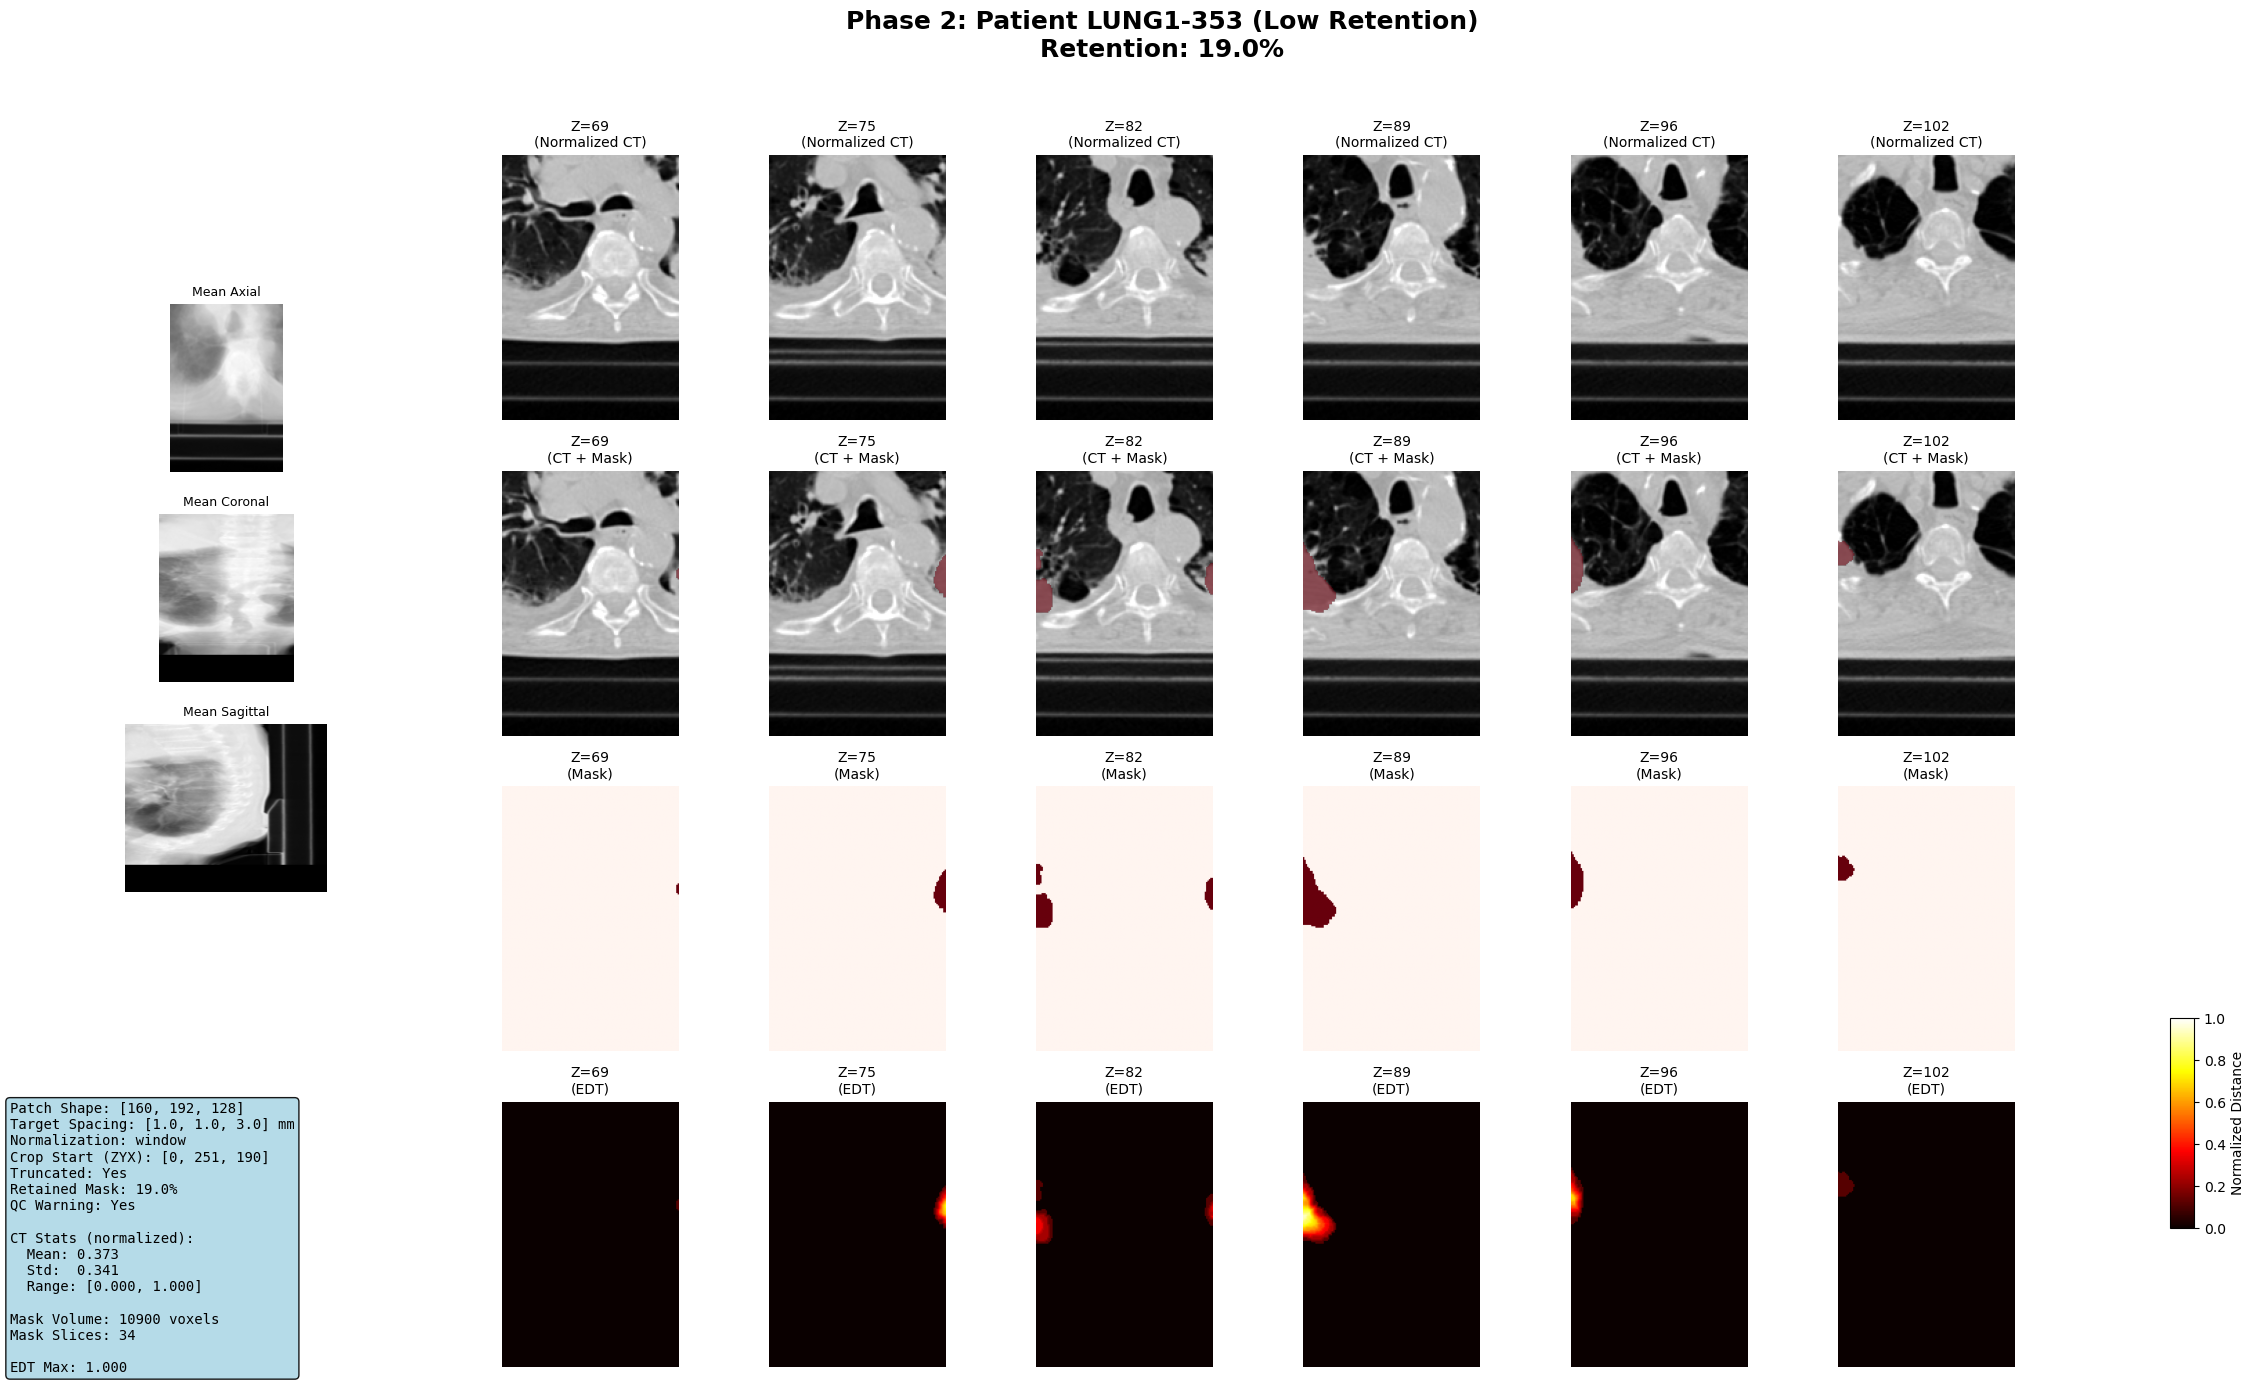

LUNG1-353: 34 slices, retention=19.0%


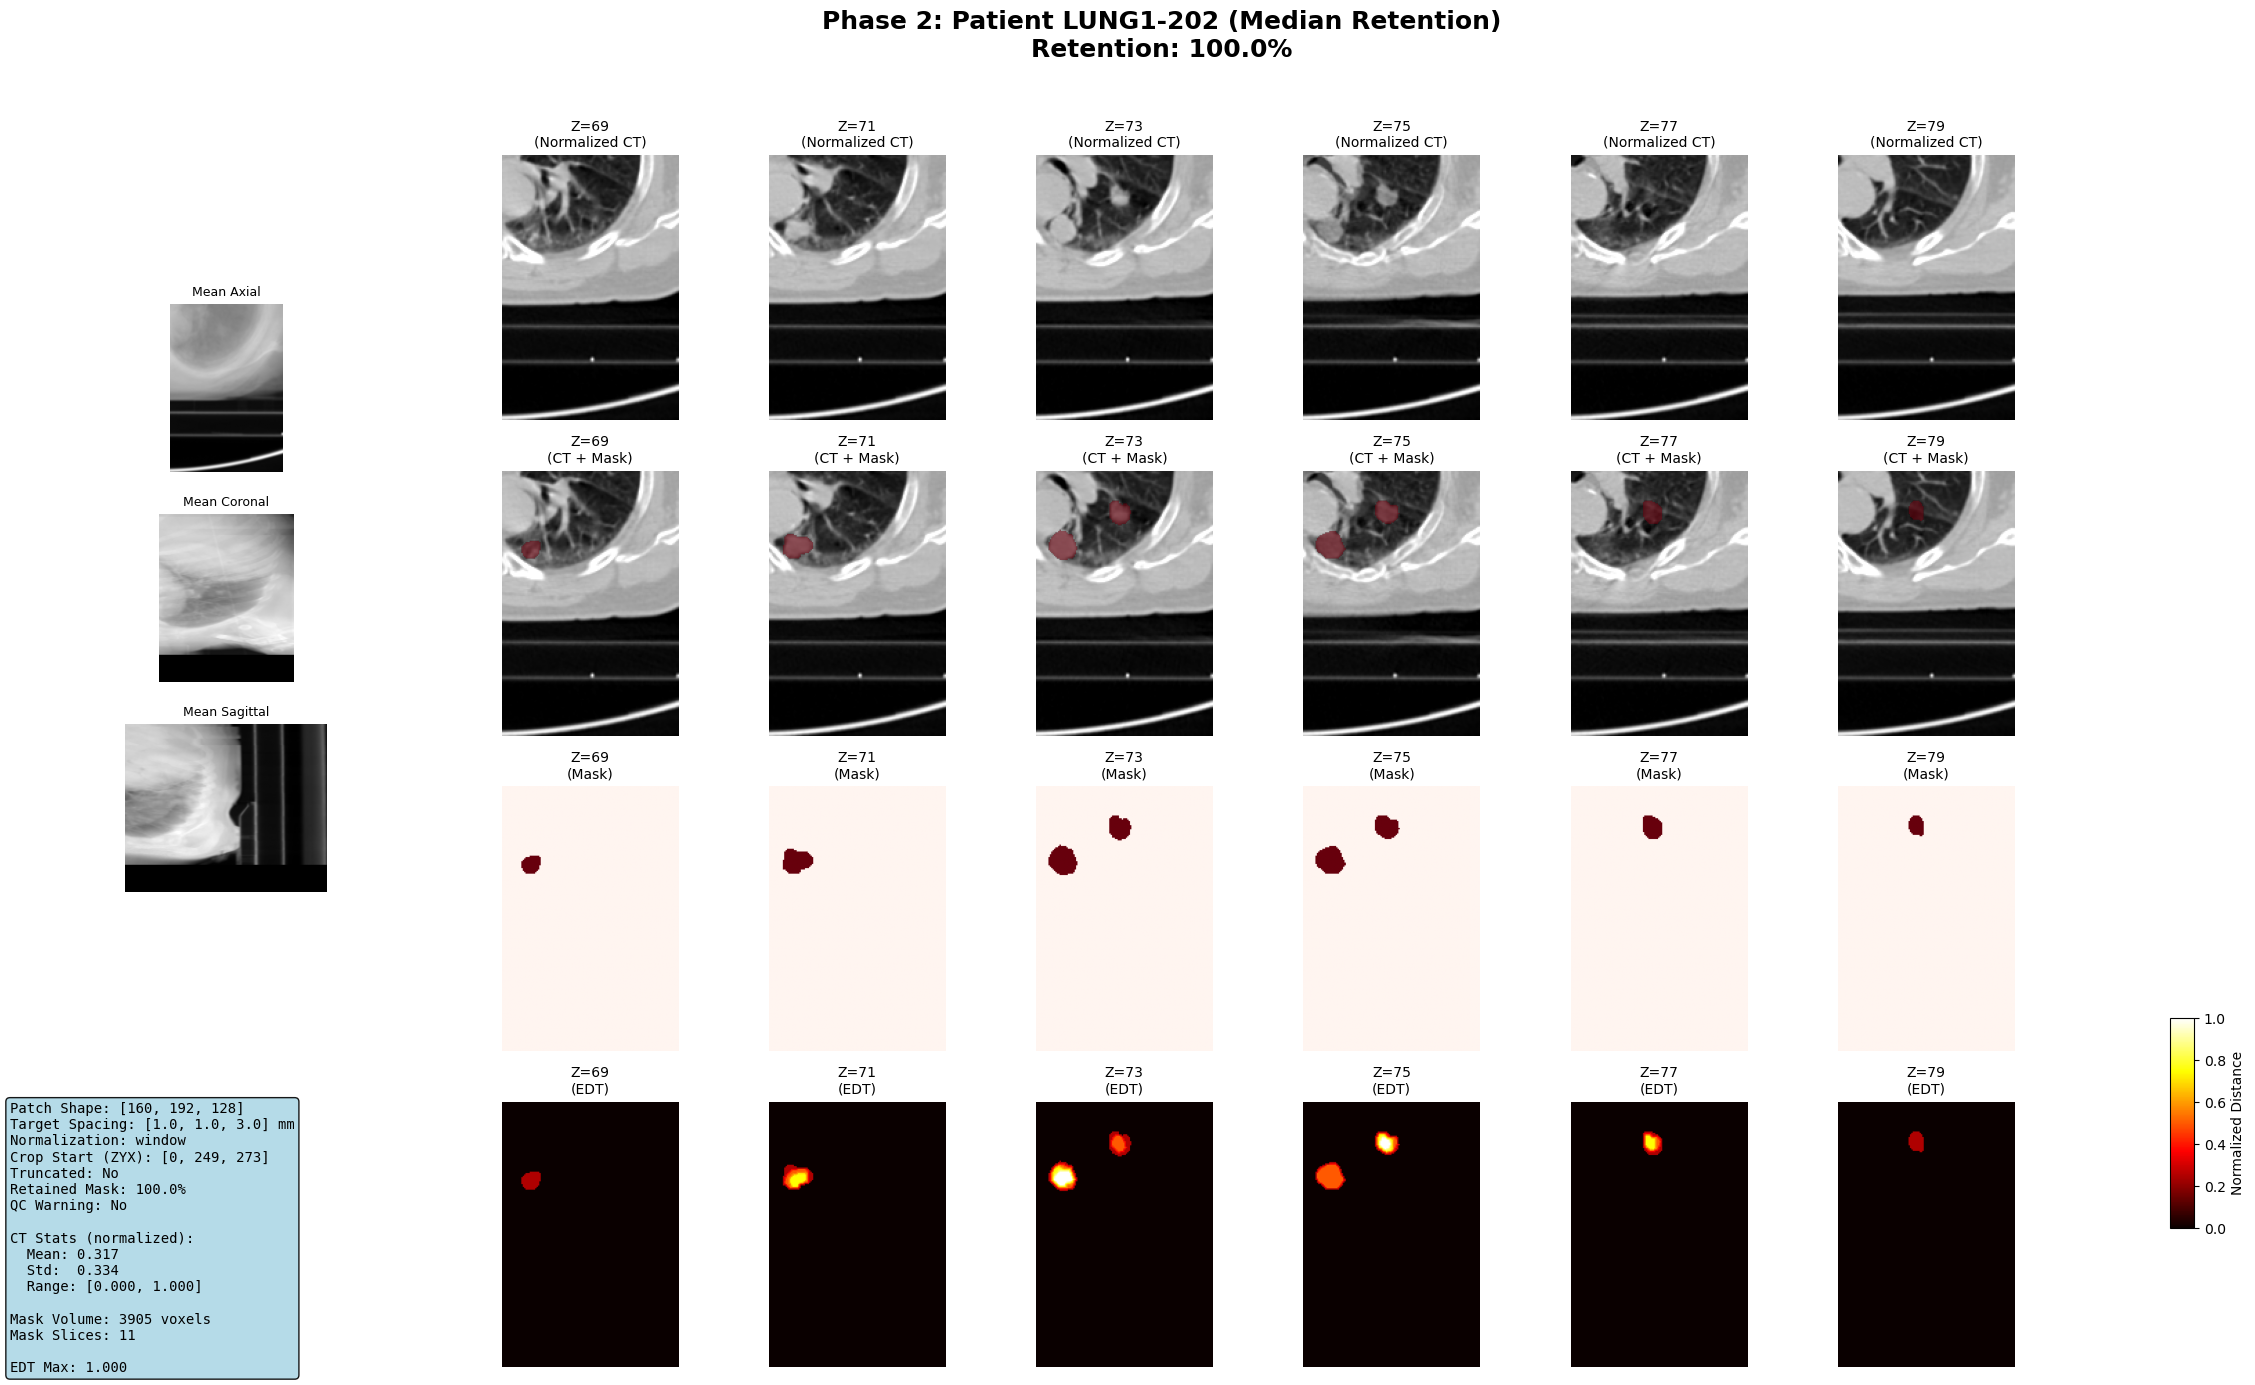

LUNG1-202: 11 slices, retention=100.0%


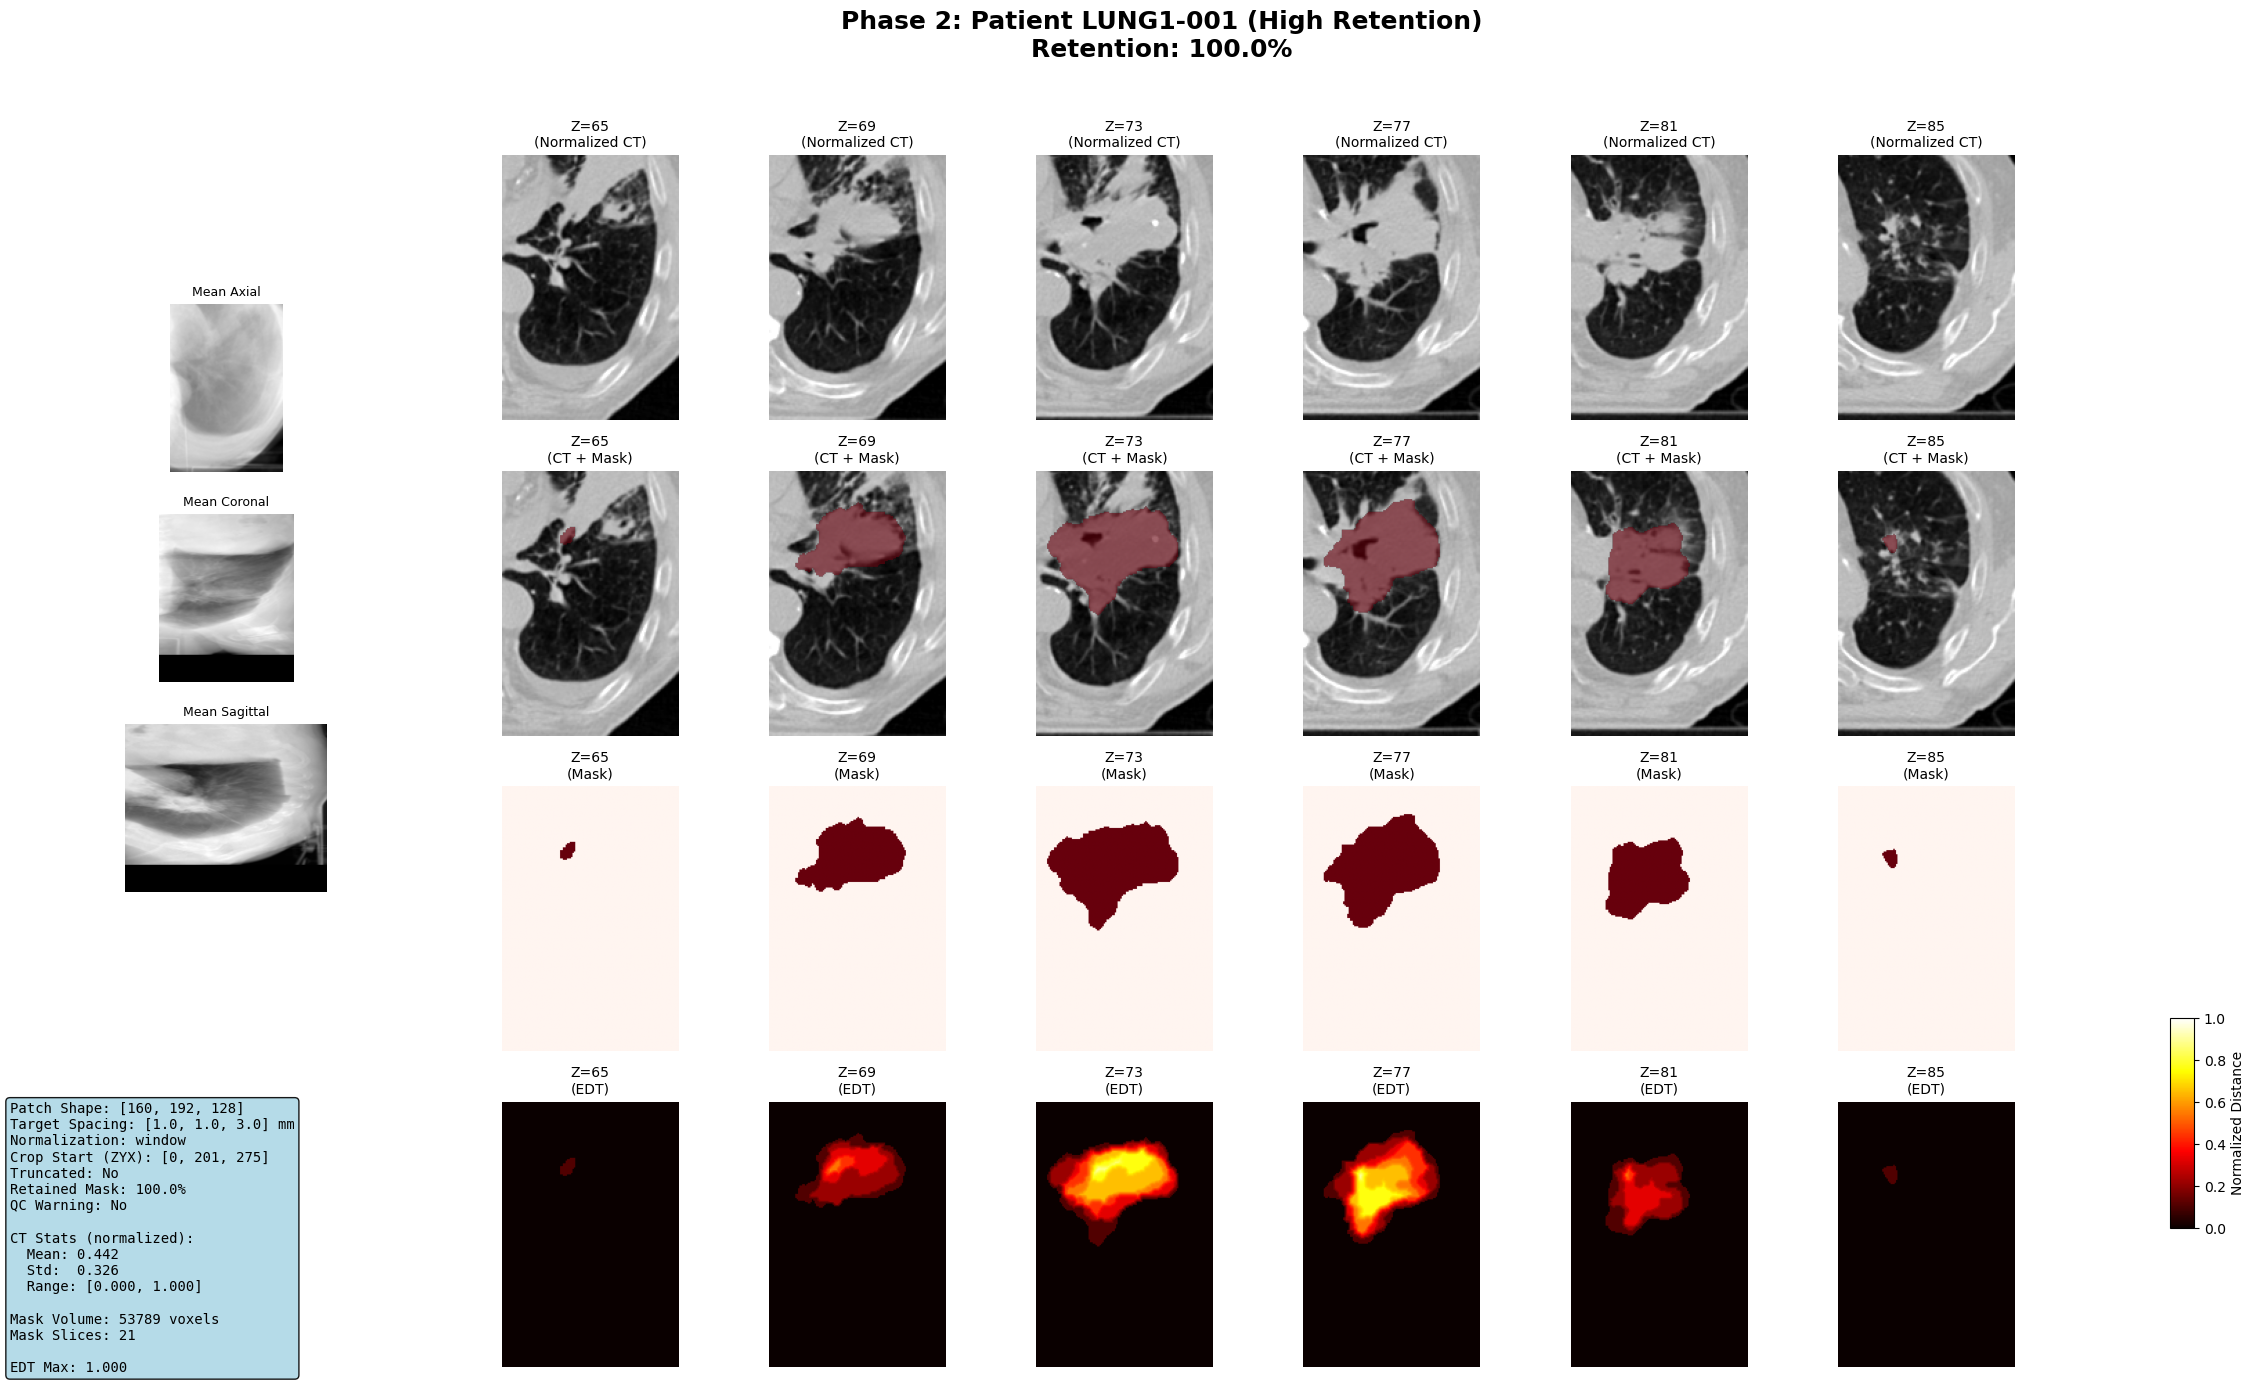

LUNG1-001: 21 slices, retention=100.0%
--------------------------------------------------------------------------------
Phase 2 visualization complete


In [1]:
# Phase 2 Visualization: Resampled, Cropped, Normalized CT/Mask/EDT
# Conda environment: ucla

import os
import numpy as np
import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
PHASE2_LOG = "/home/lichengze/Research/CNN_pipeline/phase2_outputs/crop_log.csv"

print("="*80)
print("Phase 2 Output Visualization: Resampled, Cropped, and Normalized Patches")
print("="*80)

if not os.path.exists(PHASE2_LOG):
    print(f"ERROR: Log file not found at {PHASE2_LOG}")
    print("Please run phase2_preprocessing.py first")
else:
    log_df = pd.read_csv(PHASE2_LOG)
    valid_df = log_df[log_df['out_ct'].notna()].copy()
    
    print(f"Loaded {len(log_df)} patients")
    print(f"Valid cases with outputs: {len(valid_df)}")
    
    # Select 3 representative samples based on mask retention ratio
    if len(valid_df) >= 3:
        valid_sorted = valid_df.sort_values('retained_mask_ratio')
        sample_indices = [0, len(valid_sorted)//2, len(valid_sorted)-1]
        sample_rows = [valid_sorted.iloc[i] for i in sample_indices]
        labels = ['Low Retention', 'Median Retention', 'High Retention']
    else:
        sample_rows = [valid_df.iloc[0]] if len(valid_df) > 0 else []
        labels = ['Sample']
    
    print(f"\nVisualizing {len(sample_rows)} sample cases...")
    print("-"*80)
    
    for row, label in zip(sample_rows, labels):
        patient_id = row['patient_id']
        ct_path = row['out_ct']
        mask_path = row['out_mask']
        edt_path = row['out_edt']
        
        if not os.path.exists(ct_path) or not os.path.exists(mask_path) or not os.path.exists(edt_path):
            print(f"Skipping {patient_id}: Files not found")
            continue
        
        try:
            # Load images
            ct_img = sitk.ReadImage(ct_path)
            mask_img = sitk.ReadImage(mask_path)
            edt_img = sitk.ReadImage(edt_path)
            ct_arr = sitk.GetArrayFromImage(ct_img)
            mask_arr = sitk.GetArrayFromImage(mask_img)
            edt_arr = sitk.GetArrayFromImage(edt_img)
            spacing = ct_img.GetSpacing()
            
            # Find slices containing mask
            mask_slices = np.where(mask_arr.sum(axis=(1,2)) > 0)[0]
            if len(mask_slices) == 0:
                mask_slices = [ct_arr.shape[0] // 2]
            
            # Select 6 representative slices
            if len(mask_slices) >= 6:
                indices = [
                    mask_slices[0],
                    mask_slices[len(mask_slices)//5],
                    mask_slices[2*len(mask_slices)//5],
                    mask_slices[3*len(mask_slices)//5],
                    mask_slices[4*len(mask_slices)//5],
                    mask_slices[-1]
                ]
            else:
                indices = list(mask_slices)
                while len(indices) < 6:
                    indices.append(ct_arr.shape[0] // 2)
            
            # Create visualization (4 rows x 6 columns)
            fig = plt.figure(figsize=(24, 14))
            title = f"Phase 2: Patient {patient_id} ({label})\nRetention: {row['retained_mask_ratio']*100:.1f}%"
            fig.suptitle(title, fontsize=18, fontweight='bold')
            
            # Row 1: Normalized CT
            for i, idx in enumerate(indices):
                ax = plt.subplot(4, 6, i+1)
                ax.imshow(ct_arr[idx], cmap='gray', vmin=0, vmax=1)
                ax.set_title(f'Z={idx}\n(Normalized CT)', fontsize=10)
                ax.axis('off')
            
            # Row 2: CT + Mask overlay
            for i, idx in enumerate(indices):
                ax = plt.subplot(4, 6, i+7)
                ax.imshow(ct_arr[idx], cmap='gray', vmin=0, vmax=1)
                if mask_arr[idx].sum() > 0:
                    masked = np.ma.masked_where(mask_arr[idx] == 0, mask_arr[idx])
                    ax.imshow(masked, cmap='Reds', alpha=0.6, vmin=0, vmax=1)
                ax.set_title(f'Z={idx}\n(CT + Mask)', fontsize=10)
                ax.axis('off')
            
            # Row 3: Mask only
            for i, idx in enumerate(indices):
                ax = plt.subplot(4, 6, i+13)
                ax.imshow(mask_arr[idx], cmap='Reds', vmin=0, vmax=1)
                ax.set_title(f'Z={idx}\n(Mask)', fontsize=10)
                ax.axis('off')
            
            # Row 4: EDT (Euclidean Distance Transform)
            for i, idx in enumerate(indices):
                ax = plt.subplot(4, 6, i+19)
                im = ax.imshow(edt_arr[idx], cmap='hot', vmin=0, vmax=1)
                ax.set_title(f'Z={idx}\n(EDT)', fontsize=10)
                ax.axis('off')
            
            # Add colorbar for EDT
            cbar_ax = fig.add_axes([0.92, 0.11, 0.01, 0.15])
            plt.colorbar(im, cax=cbar_ax, label='Normalized Distance')
            
            # Add 3D projections (mean intensity projection)
            ax_axial = fig.add_axes([0.05, 0.65, 0.12, 0.12])
            ax_axial.imshow(ct_arr.mean(axis=0), cmap='gray')
            ax_axial.set_title('Mean Axial', fontsize=9)
            ax_axial.axis('off')
            
            ax_coronal = fig.add_axes([0.05, 0.50, 0.12, 0.12])
            ax_coronal.imshow(ct_arr.mean(axis=1), cmap='gray')
            ax_coronal.set_title('Mean Coronal', fontsize=9)
            ax_coronal.axis('off')
            
            ax_sagittal = fig.add_axes([0.05, 0.35, 0.12, 0.12])
            ax_sagittal.imshow(ct_arr.mean(axis=2), cmap='gray')
            ax_sagittal.set_title('Mean Sagittal', fontsize=9)
            ax_sagittal.axis('off')
            
            # Add metadata
            info_text = (
                f"Patch Shape: {row.get('patch_shape', 'N/A')}\n"
                f"Target Spacing: {row.get('spacing', 'N/A')} mm\n"
                f"Normalization: {row.get('norm', 'N/A')}\n"
                f"Crop Start (ZYX): {row.get('crop_start', 'N/A')}\n"
                f"Truncated: {'Yes' if row.get('truncated', False) else 'No'}\n"
                f"Retained Mask: {row['retained_mask_ratio']*100:.1f}%\n"
                f"QC Warning: {'Yes' if row.get('qc_warning', False) else 'No'}\n\n"
                f"CT Stats (normalized):\n"
                f"  Mean: {ct_arr.mean():.3f}\n"
                f"  Std:  {ct_arr.std():.3f}\n"
                f"  Range: [{ct_arr.min():.3f}, {ct_arr.max():.3f}]\n\n"
                f"Mask Volume: {mask_arr.sum()} voxels\n"
                f"Mask Slices: {len(mask_slices)}\n\n"
                f"EDT Max: {edt_arr.max():.3f}"
            )
            fig.text(0.02, 0.20, info_text, fontsize=10,
                     verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.9),
                     family='monospace')
            
            plt.tight_layout(rect=[0.18, 0, 0.90, 0.96])
            plt.show()
            
            print(f"{patient_id}: {len(mask_slices)} slices, retention={row['retained_mask_ratio']*100:.1f}%")
            
        except Exception as e:
            print(f"{patient_id}: Error - {e}")
    
    print("-"*80)
    print("Phase 2 visualization complete")
    print("="*80)
